Running Vulnerable Scenario (Average)...

--- Starting Simulation with Aggregator: Average ---
Round 5/20: Test Accuracy = 14.68%
Round 10/20: Test Accuracy = 14.58%
Round 15/20: Test Accuracy = 14.28%
Round 20/20: Test Accuracy = 14.04%
Running Robust Scenario (TrimmedMean)...

--- Starting Simulation with Aggregator: TrimmedMean ---
Round 5/20: Test Accuracy = 20.18%
Round 10/20: Test Accuracy = 27.96%
Round 15/20: Test Accuracy = 35.26%
Round 20/20: Test Accuracy = 44.54%


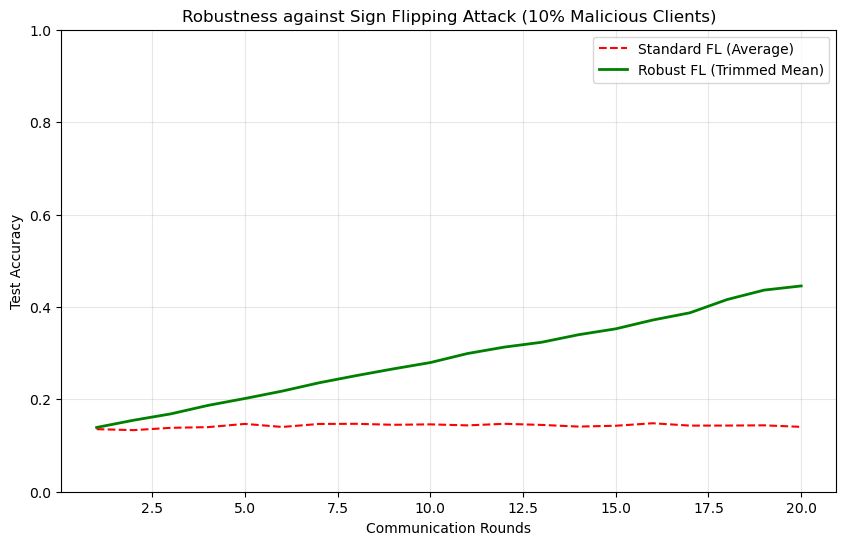


Simulation complete. Plot generated.


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import byzfl
import copy
import matplotlib.pyplot as plt  # Necessary for plotting

# --- 1. Experimental Setup ---
NUM_CLIENTS = 10
NUM_BYZANTINE = 1   # 20% malicious nodes
ROUNDS = 20        # Reduced to 50 for faster demonstration (increase if needed)
BATCH_SIZE = 32
LR = 0.01

device = torch.device("cpu")

# --- 2. Data Preparation (MNIST) ---
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Download and load training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
# Download and load test data (defined globally for efficiency)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)

# Simulate clients by splitting the training dataset
client_data_len = len(train_dataset) // NUM_CLIENTS
client_datasets = torch.utils.data.random_split(train_dataset, [client_data_len]*NUM_CLIENTS)

# --- 3. Model Definition ---
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def evaluate(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return correct / len(loader.dataset)

# --- 4. Federated Training Loop ---

def run_simulation(aggregator_name):
    print(f"\n--- Starting Simulation with Aggregator: {aggregator_name} ---")
    
    global_model = SimpleMLP().to(device)
    accuracy_history = [] # List to store accuracy per round
    
    # Initialize Aggregator
    if aggregator_name == "Average":
        # Standard mean aggregation (Vulnerable)
        aggregator = byzfl.Average() 
    elif aggregator_name == "TrimmedMean":
        # Robust aggregation: Discards extreme values
        # Beta is the number of neighbors to discard on each side
        aggregator = byzfl.TrMean(NUM_BYZANTINE)
        
    for r in range(ROUNDS):
        local_gradients = []
        
        # A. Client Local Training
        for client_idx in range(NUM_CLIENTS):
            local_model = copy.deepcopy(global_model)
            local_model.train()
            
            # Get a batch
            loader = torch.utils.data.DataLoader(client_datasets[client_idx], batch_size=BATCH_SIZE, shuffle=True)
            data, target = next(iter(loader))
            
            # Compute Gradient
            output = local_model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            
            # Flatten gradients
            grads = torch.cat([p.grad.flatten() for p in local_model.parameters()])
            
            # B. Attack Simulation (Sign Flipping)
            if client_idx < NUM_BYZANTINE:
                # Malicious: Flip sign and scale to drag the mean
                grads = -1.0 * grads * 10.0
            
            local_gradients.append(grads)

        # C. Server Aggregation
        stacked_grads = torch.stack(local_gradients)
        aggregated_grad = aggregator(stacked_grads)
        
        # D. Update Global Model
        start_idx = 0
        with torch.no_grad():
            for param in global_model.parameters():
                num_params = param.numel()
                grad_chunk = aggregated_grad[start_idx : start_idx + num_params].view(param.shape)
                param -= LR * grad_chunk
                start_idx += num_params

        # E. Record Accuracy
        acc = evaluate(global_model, test_loader)
        accuracy_history.append(acc)
        
        if (r+1) % 5 == 0:
            print(f"Round {r+1}/{ROUNDS}: Test Accuracy = {acc:.2%}")

    return accuracy_history

# --- 5. Execution & Plotting ---

# Run Scenarios

print("Running Vulnerable Scenario (Average)...")
acc_avg = run_simulation("Average")

print("Running Robust Scenario (TrimmedMean)...")
acc_tm = run_simulation("TrimmedMean")

# Plotting Results
plt.figure(figsize=(10, 6))
plt.plot(range(1, ROUNDS + 1), acc_avg, label='Standard FL (Average)', color='red', linestyle='--')
plt.plot(range(1, ROUNDS + 1), acc_tm, label='Robust FL (Trimmed Mean)', color='green', linewidth=2)

plt.title(f'Robustness against Sign Flipping Attack ({NUM_BYZANTINE/NUM_CLIENTS:.0%} Malicious Clients)')
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, 1.0) # Accuracy is between 0 and 1

# Save or Show
plt.savefig('federated_attack_simulation.png')
plt.show()

print("\nSimulation complete. Plot generated.")